In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
output_notebook()
%matplotlib inline

Loading BokehJS ...

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [3]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [7]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [8]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r
    

In [9]:
obj_1 = scaler(-1,1)
obj_1.fit(X_rg)
X_train = obj_1.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [10]:
X_cand = datos.drop(rg)
X_cand.shape

(4185, 9)

In [12]:
X_cand = obj_1.transform(X_cand)
X_cand.shape

(4185, 9)

In [13]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [14]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(Dropout(.1))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [15]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [16]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [17]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    precision = []
    recall = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        recall.append(recall_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, precision, recall

In [23]:
noise_input = 50
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/1500)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/1500)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [24]:
ep = 1500
g_loss, d_loss, precision, recall = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/1500] [Discriminator::d_loss: 0.682666],[Generator::loss: 0.880529], 0.789616[sec]
epoch:[2/1500] [Discriminator::d_loss: 0.678961],[Generator::loss: 0.789493], 0.010090[sec]
epoch:[3/1500] [Discriminator::d_loss: 0.684139],[Generator::loss: 0.851985], 0.009692[sec]
epoch:[4/1500] [Discriminator::d_loss: 0.665841],[Generator::loss: 0.792669], 0.009571[sec]
epoch:[5/1500] [Discriminator::d_loss: 0.670900],[Generator::loss: 0.839249], 0.009695[sec]
epoch:[6/1500] [Discriminator::d_loss: 0.684415],[Generator::loss: 0.842523], 0.009212[sec]
epoch:[7/1500] [Discriminator::d_loss: 0.672945],[Generator::loss: 0.819592], 0.009176[sec]
epoch:[8/1500] [Discriminator::d_loss: 0.692511],[Generator::loss: 0.831982], 0.009902[sec]
epoch:[9/1500] [Discriminator::d_loss: 0.690814],[Generator::loss: 0.832205], 0.009232[sec]
epoch:[10/1500] [Discriminator::d_loss: 0.655877],[Generator::loss: 0.786907], 0.009250[sec]
epoch:[11/1500] [Discriminator::d_loss: 0.673584],[Generator::loss: 0.789834], 

epoch:[105/1500] [Discriminator::d_loss: 0.625615],[Generator::loss: 0.794242], 0.009466[sec]
epoch:[106/1500] [Discriminator::d_loss: 0.578199],[Generator::loss: 0.728307], 0.011313[sec]
epoch:[107/1500] [Discriminator::d_loss: 0.623140],[Generator::loss: 0.762352], 0.014546[sec]
epoch:[108/1500] [Discriminator::d_loss: 0.604837],[Generator::loss: 0.742903], 0.009293[sec]
epoch:[109/1500] [Discriminator::d_loss: 0.590324],[Generator::loss: 0.779824], 0.009436[sec]
epoch:[110/1500] [Discriminator::d_loss: 0.605686],[Generator::loss: 0.779242], 0.009201[sec]
epoch:[111/1500] [Discriminator::d_loss: 0.603661],[Generator::loss: 0.747866], 0.009129[sec]
epoch:[112/1500] [Discriminator::d_loss: 0.589975],[Generator::loss: 0.811778], 0.009212[sec]
epoch:[113/1500] [Discriminator::d_loss: 0.592602],[Generator::loss: 0.789893], 0.009035[sec]
epoch:[114/1500] [Discriminator::d_loss: 0.593992],[Generator::loss: 0.782849], 0.009055[sec]
epoch:[115/1500] [Discriminator::d_loss: 0.590461],[Generato

epoch:[207/1500] [Discriminator::d_loss: 0.565630],[Generator::loss: 0.768529], 0.013537[sec]
epoch:[208/1500] [Discriminator::d_loss: 0.536565],[Generator::loss: 0.894649], 0.012475[sec]
epoch:[209/1500] [Discriminator::d_loss: 0.568074],[Generator::loss: 0.767404], 0.011861[sec]
epoch:[210/1500] [Discriminator::d_loss: 0.573530],[Generator::loss: 0.910844], 0.016019[sec]
epoch:[211/1500] [Discriminator::d_loss: 0.535713],[Generator::loss: 0.822634], 0.013125[sec]
epoch:[212/1500] [Discriminator::d_loss: 0.577867],[Generator::loss: 0.771686], 0.010156[sec]
epoch:[213/1500] [Discriminator::d_loss: 0.597423],[Generator::loss: 0.884510], 0.010382[sec]
epoch:[214/1500] [Discriminator::d_loss: 0.547062],[Generator::loss: 0.864336], 0.009643[sec]
epoch:[215/1500] [Discriminator::d_loss: 0.563089],[Generator::loss: 0.805146], 0.011077[sec]
epoch:[216/1500] [Discriminator::d_loss: 0.544210],[Generator::loss: 0.896063], 0.010372[sec]
epoch:[217/1500] [Discriminator::d_loss: 0.566473],[Generato

epoch:[315/1500] [Discriminator::d_loss: 0.555004],[Generator::loss: 0.830919], 0.010364[sec]
epoch:[316/1500] [Discriminator::d_loss: 0.557325],[Generator::loss: 0.946883], 0.011438[sec]
epoch:[317/1500] [Discriminator::d_loss: 0.578744],[Generator::loss: 0.866128], 0.009613[sec]
epoch:[318/1500] [Discriminator::d_loss: 0.548377],[Generator::loss: 0.962556], 0.009306[sec]
epoch:[319/1500] [Discriminator::d_loss: 0.536532],[Generator::loss: 0.828266], 0.009324[sec]
epoch:[320/1500] [Discriminator::d_loss: 0.560335],[Generator::loss: 0.830492], 0.009221[sec]
epoch:[321/1500] [Discriminator::d_loss: 0.559099],[Generator::loss: 0.854371], 0.009411[sec]
epoch:[322/1500] [Discriminator::d_loss: 0.496985],[Generator::loss: 0.923744], 0.009164[sec]
epoch:[323/1500] [Discriminator::d_loss: 0.538897],[Generator::loss: 0.897633], 0.009164[sec]
epoch:[324/1500] [Discriminator::d_loss: 0.525135],[Generator::loss: 0.889976], 0.009795[sec]
epoch:[325/1500] [Discriminator::d_loss: 0.531949],[Generato

epoch:[420/1500] [Discriminator::d_loss: 0.525970],[Generator::loss: 0.852543], 0.011168[sec]
epoch:[421/1500] [Discriminator::d_loss: 0.514560],[Generator::loss: 0.844928], 0.011026[sec]
epoch:[422/1500] [Discriminator::d_loss: 0.564508],[Generator::loss: 0.879528], 0.009724[sec]
epoch:[423/1500] [Discriminator::d_loss: 0.510877],[Generator::loss: 0.948178], 0.009379[sec]
epoch:[424/1500] [Discriminator::d_loss: 0.570727],[Generator::loss: 0.933782], 0.010068[sec]
epoch:[425/1500] [Discriminator::d_loss: 0.531016],[Generator::loss: 0.919060], 0.009503[sec]
epoch:[426/1500] [Discriminator::d_loss: 0.579930],[Generator::loss: 0.803988], 0.009935[sec]
epoch:[427/1500] [Discriminator::d_loss: 0.550377],[Generator::loss: 0.785388], 0.009556[sec]
epoch:[428/1500] [Discriminator::d_loss: 0.564395],[Generator::loss: 0.970019], 0.009977[sec]
epoch:[429/1500] [Discriminator::d_loss: 0.586839],[Generator::loss: 0.815560], 0.009987[sec]
epoch:[430/1500] [Discriminator::d_loss: 0.563071],[Generato

epoch:[526/1500] [Discriminator::d_loss: 0.512412],[Generator::loss: 0.908220], 0.011928[sec]
epoch:[527/1500] [Discriminator::d_loss: 0.618190],[Generator::loss: 0.971366], 0.012258[sec]
epoch:[528/1500] [Discriminator::d_loss: 0.514269],[Generator::loss: 0.916767], 0.009387[sec]
epoch:[529/1500] [Discriminator::d_loss: 0.557166],[Generator::loss: 0.843520], 0.009516[sec]
epoch:[530/1500] [Discriminator::d_loss: 0.516527],[Generator::loss: 0.983532], 0.009406[sec]
epoch:[531/1500] [Discriminator::d_loss: 0.654184],[Generator::loss: 0.964908], 0.009637[sec]
epoch:[532/1500] [Discriminator::d_loss: 0.589568],[Generator::loss: 0.893548], 0.009508[sec]
epoch:[533/1500] [Discriminator::d_loss: 0.610301],[Generator::loss: 0.867816], 0.009358[sec]
epoch:[534/1500] [Discriminator::d_loss: 0.592011],[Generator::loss: 0.853306], 0.009621[sec]
epoch:[535/1500] [Discriminator::d_loss: 0.583616],[Generator::loss: 0.971983], 0.009138[sec]
epoch:[536/1500] [Discriminator::d_loss: 0.590317],[Generato

epoch:[631/1500] [Discriminator::d_loss: 0.614099],[Generator::loss: 0.857251], 0.014351[sec]
epoch:[632/1500] [Discriminator::d_loss: 0.570339],[Generator::loss: 0.859582], 0.011906[sec]
epoch:[633/1500] [Discriminator::d_loss: 0.589977],[Generator::loss: 0.815574], 0.009441[sec]
epoch:[634/1500] [Discriminator::d_loss: 0.658433],[Generator::loss: 0.761636], 0.009358[sec]
epoch:[635/1500] [Discriminator::d_loss: 0.603557],[Generator::loss: 0.914276], 0.009468[sec]
epoch:[636/1500] [Discriminator::d_loss: 0.597502],[Generator::loss: 0.825279], 0.009413[sec]
epoch:[637/1500] [Discriminator::d_loss: 0.576736],[Generator::loss: 0.920512], 0.009486[sec]
epoch:[638/1500] [Discriminator::d_loss: 0.596983],[Generator::loss: 0.766112], 0.009109[sec]
epoch:[639/1500] [Discriminator::d_loss: 0.567409],[Generator::loss: 0.773993], 0.009219[sec]
epoch:[640/1500] [Discriminator::d_loss: 0.613298],[Generator::loss: 0.773737], 0.009300[sec]
epoch:[641/1500] [Discriminator::d_loss: 0.641836],[Generato

epoch:[737/1500] [Discriminator::d_loss: 0.641835],[Generator::loss: 0.816065], 0.010750[sec]
epoch:[738/1500] [Discriminator::d_loss: 0.605006],[Generator::loss: 0.719802], 0.011224[sec]
epoch:[739/1500] [Discriminator::d_loss: 0.571943],[Generator::loss: 0.892103], 0.009402[sec]
epoch:[740/1500] [Discriminator::d_loss: 0.576716],[Generator::loss: 0.784018], 0.009344[sec]
epoch:[741/1500] [Discriminator::d_loss: 0.637850],[Generator::loss: 0.974853], 0.009459[sec]
epoch:[742/1500] [Discriminator::d_loss: 0.686118],[Generator::loss: 0.790002], 0.009368[sec]
epoch:[743/1500] [Discriminator::d_loss: 0.649750],[Generator::loss: 0.831142], 0.009499[sec]
epoch:[744/1500] [Discriminator::d_loss: 0.606335],[Generator::loss: 0.958780], 0.009227[sec]
epoch:[745/1500] [Discriminator::d_loss: 0.601162],[Generator::loss: 0.883593], 0.009380[sec]
epoch:[746/1500] [Discriminator::d_loss: 0.631590],[Generator::loss: 0.956902], 0.009376[sec]
epoch:[747/1500] [Discriminator::d_loss: 0.573359],[Generato

epoch:[831/1500] [Discriminator::d_loss: 0.643732],[Generator::loss: 0.847448], 0.017817[sec]
epoch:[832/1500] [Discriminator::d_loss: 0.629317],[Generator::loss: 0.908190], 0.015755[sec]
epoch:[833/1500] [Discriminator::d_loss: 0.682339],[Generator::loss: 0.728598], 0.018865[sec]
epoch:[834/1500] [Discriminator::d_loss: 0.685351],[Generator::loss: 0.759907], 0.014434[sec]
epoch:[835/1500] [Discriminator::d_loss: 0.660222],[Generator::loss: 0.810402], 0.011245[sec]
epoch:[836/1500] [Discriminator::d_loss: 0.688910],[Generator::loss: 0.680995], 0.017095[sec]
epoch:[837/1500] [Discriminator::d_loss: 0.726437],[Generator::loss: 0.852829], 0.013553[sec]
epoch:[838/1500] [Discriminator::d_loss: 0.648006],[Generator::loss: 0.818262], 0.014000[sec]
epoch:[839/1500] [Discriminator::d_loss: 0.676952],[Generator::loss: 0.767097], 0.017065[sec]
epoch:[840/1500] [Discriminator::d_loss: 0.657801],[Generator::loss: 0.743787], 0.015634[sec]
epoch:[841/1500] [Discriminator::d_loss: 0.713716],[Generato

epoch:[919/1500] [Discriminator::d_loss: 0.707585],[Generator::loss: 0.793382], 0.011396[sec]
epoch:[920/1500] [Discriminator::d_loss: 0.648249],[Generator::loss: 0.855294], 0.012545[sec]
epoch:[921/1500] [Discriminator::d_loss: 0.686625],[Generator::loss: 0.844394], 0.010942[sec]
epoch:[922/1500] [Discriminator::d_loss: 0.717663],[Generator::loss: 0.791101], 0.010540[sec]
epoch:[923/1500] [Discriminator::d_loss: 0.701857],[Generator::loss: 0.763289], 0.010367[sec]
epoch:[924/1500] [Discriminator::d_loss: 0.707901],[Generator::loss: 0.888291], 0.009679[sec]
epoch:[925/1500] [Discriminator::d_loss: 0.697216],[Generator::loss: 0.793439], 0.009105[sec]
epoch:[926/1500] [Discriminator::d_loss: 0.784127],[Generator::loss: 0.700922], 0.009696[sec]
epoch:[927/1500] [Discriminator::d_loss: 0.667275],[Generator::loss: 0.754280], 0.009912[sec]
epoch:[928/1500] [Discriminator::d_loss: 0.686706],[Generator::loss: 0.736248], 0.010202[sec]
epoch:[929/1500] [Discriminator::d_loss: 0.670550],[Generato

epoch:[1022/1500] [Discriminator::d_loss: 0.705466],[Generator::loss: 0.715892], 0.010133[sec]
epoch:[1023/1500] [Discriminator::d_loss: 0.737570],[Generator::loss: 0.753726], 0.011838[sec]
epoch:[1024/1500] [Discriminator::d_loss: 0.705523],[Generator::loss: 0.749737], 0.009479[sec]
epoch:[1025/1500] [Discriminator::d_loss: 0.729740],[Generator::loss: 0.778814], 0.009558[sec]
epoch:[1026/1500] [Discriminator::d_loss: 0.693947],[Generator::loss: 0.671487], 0.010299[sec]
epoch:[1027/1500] [Discriminator::d_loss: 0.693252],[Generator::loss: 0.720867], 0.010048[sec]
epoch:[1028/1500] [Discriminator::d_loss: 0.724166],[Generator::loss: 0.781386], 0.010061[sec]
epoch:[1029/1500] [Discriminator::d_loss: 0.701929],[Generator::loss: 0.884912], 0.009662[sec]
epoch:[1030/1500] [Discriminator::d_loss: 0.734522],[Generator::loss: 0.783097], 0.009521[sec]
epoch:[1031/1500] [Discriminator::d_loss: 0.702899],[Generator::loss: 0.802294], 0.009306[sec]
epoch:[1032/1500] [Discriminator::d_loss: 0.716910

epoch:[1127/1500] [Discriminator::d_loss: 0.661624],[Generator::loss: 0.724269], 0.011330[sec]
epoch:[1128/1500] [Discriminator::d_loss: 0.682893],[Generator::loss: 0.800704], 0.010928[sec]
epoch:[1129/1500] [Discriminator::d_loss: 0.679326],[Generator::loss: 0.724369], 0.009724[sec]
epoch:[1130/1500] [Discriminator::d_loss: 0.723411],[Generator::loss: 0.751217], 0.009153[sec]
epoch:[1131/1500] [Discriminator::d_loss: 0.705342],[Generator::loss: 0.776439], 0.009273[sec]
epoch:[1132/1500] [Discriminator::d_loss: 0.709762],[Generator::loss: 0.736446], 0.009307[sec]
epoch:[1133/1500] [Discriminator::d_loss: 0.684662],[Generator::loss: 0.700412], 0.009293[sec]
epoch:[1134/1500] [Discriminator::d_loss: 0.717569],[Generator::loss: 0.691125], 0.009466[sec]
epoch:[1135/1500] [Discriminator::d_loss: 0.654019],[Generator::loss: 0.747148], 0.009324[sec]
epoch:[1136/1500] [Discriminator::d_loss: 0.728412],[Generator::loss: 0.794754], 0.009207[sec]
epoch:[1137/1500] [Discriminator::d_loss: 0.683677

epoch:[1233/1500] [Discriminator::d_loss: 0.685660],[Generator::loss: 0.697983], 0.010394[sec]
epoch:[1234/1500] [Discriminator::d_loss: 0.657511],[Generator::loss: 0.725596], 0.011558[sec]
epoch:[1235/1500] [Discriminator::d_loss: 0.690947],[Generator::loss: 0.766357], 0.009414[sec]
epoch:[1236/1500] [Discriminator::d_loss: 0.679744],[Generator::loss: 0.733867], 0.009428[sec]
epoch:[1237/1500] [Discriminator::d_loss: 0.714984],[Generator::loss: 0.780799], 0.009387[sec]
epoch:[1238/1500] [Discriminator::d_loss: 0.703735],[Generator::loss: 0.755787], 0.009545[sec]
epoch:[1239/1500] [Discriminator::d_loss: 0.716491],[Generator::loss: 0.790269], 0.010202[sec]
epoch:[1240/1500] [Discriminator::d_loss: 0.678365],[Generator::loss: 0.798120], 0.010016[sec]
epoch:[1241/1500] [Discriminator::d_loss: 0.730500],[Generator::loss: 0.755367], 0.009843[sec]
epoch:[1242/1500] [Discriminator::d_loss: 0.706676],[Generator::loss: 0.728833], 0.009824[sec]
epoch:[1243/1500] [Discriminator::d_loss: 0.707626

epoch:[1338/1500] [Discriminator::d_loss: 0.688950],[Generator::loss: 0.698108], 0.009144[sec]
epoch:[1339/1500] [Discriminator::d_loss: 0.667788],[Generator::loss: 0.748004], 0.014394[sec]
epoch:[1340/1500] [Discriminator::d_loss: 0.698989],[Generator::loss: 0.770692], 0.009544[sec]
epoch:[1341/1500] [Discriminator::d_loss: 0.682883],[Generator::loss: 0.721481], 0.009752[sec]
epoch:[1342/1500] [Discriminator::d_loss: 0.681924],[Generator::loss: 0.731045], 0.009412[sec]
epoch:[1343/1500] [Discriminator::d_loss: 0.675271],[Generator::loss: 0.801996], 0.009511[sec]
epoch:[1344/1500] [Discriminator::d_loss: 0.690803],[Generator::loss: 0.730514], 0.009347[sec]
epoch:[1345/1500] [Discriminator::d_loss: 0.676959],[Generator::loss: 0.789717], 0.009129[sec]
epoch:[1346/1500] [Discriminator::d_loss: 0.701467],[Generator::loss: 0.813525], 0.009275[sec]
epoch:[1347/1500] [Discriminator::d_loss: 0.679742],[Generator::loss: 0.722507], 0.009096[sec]
epoch:[1348/1500] [Discriminator::d_loss: 0.698544

epoch:[1438/1500] [Discriminator::d_loss: 0.681977],[Generator::loss: 0.743657], 0.016973[sec]
epoch:[1439/1500] [Discriminator::d_loss: 0.695864],[Generator::loss: 0.757948], 0.015752[sec]
epoch:[1440/1500] [Discriminator::d_loss: 0.657880],[Generator::loss: 0.722158], 0.011039[sec]
epoch:[1441/1500] [Discriminator::d_loss: 0.668287],[Generator::loss: 0.802429], 0.013832[sec]
epoch:[1442/1500] [Discriminator::d_loss: 0.666100],[Generator::loss: 0.709947], 0.009585[sec]
epoch:[1443/1500] [Discriminator::d_loss: 0.682860],[Generator::loss: 0.778859], 0.010282[sec]
epoch:[1444/1500] [Discriminator::d_loss: 0.679645],[Generator::loss: 0.729227], 0.009588[sec]
epoch:[1445/1500] [Discriminator::d_loss: 0.683051],[Generator::loss: 0.761200], 0.010668[sec]
epoch:[1446/1500] [Discriminator::d_loss: 0.680467],[Generator::loss: 0.781636], 0.009168[sec]
epoch:[1447/1500] [Discriminator::d_loss: 0.688508],[Generator::loss: 0.707689], 0.010828[sec]
epoch:[1448/1500] [Discriminator::d_loss: 0.678621

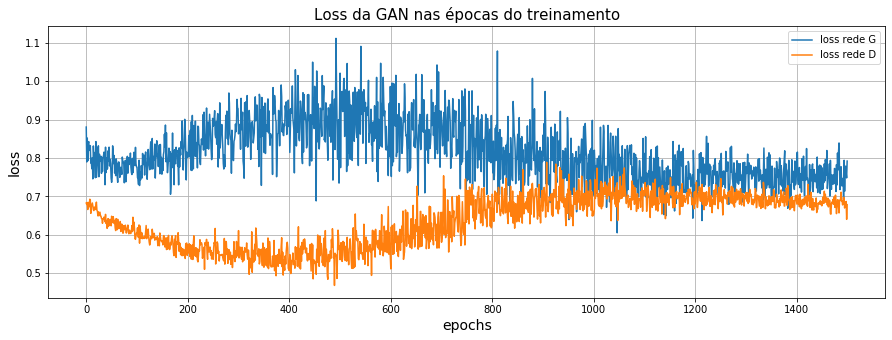

In [25]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

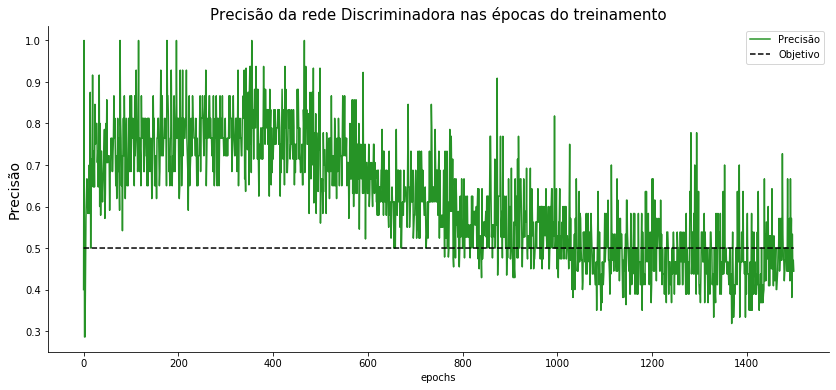

In [26]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

In [28]:
t_i = time()
m_precision = []
m_recall = []
m_f1score = []
m_accuracy = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    m_precision.append(precision_score(y_test, y_predict))
    m_recall.append(recall_score(y_test, y_predict))
    m_f1score.append(f1_score(y_test, y_predict))
    m_accuracy.append(accuracy_score(y_test, y_predict))
t_f = time()
print("tempo de execução: ", t_f-t_i, "[s]")

tempo de execução:  27.99337124824524 [s]


In [29]:
def boxtplot_values(v):
    """
    return the values to plot a boxplot with ouliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]
    
    return [lower, q25, q50, q75, upper], outliers

In [32]:
[pl, pq1, pq2, pq3, pu], pouts = boxtplot_values(np.array(m_precision))
[rl, rq1, rq2, rq3, ru], routs = boxtplot_values(np.array(m_recall))
[fl, fq1, fq2, fq3, fu], fouts = boxtplot_values(np.array(m_f1score))
[al, aq1, aq2, aq3, au], aouts = boxtplot_values(np.array(m_accuracy))

In [76]:
cats = ["Accuray", "Precision", "Recall", "F1-score"]
p = figure(tools="", background_fill_color="#efefef", x_range=cats, toolbar_location=None,
          plot_height=400, title="Discriminator metrics")


p.segment(cats, [aq3,pq3,rq3,fq3], cats, [au,pu,ru,fu], line_color="black")
p.segment(cats, [al,pl,rl,fl], cats, [aq1,pq1,rq1,fq1], line_color="black")
# boxes
p.vbar(cats, 0.4, [aq2,pq2,rq2,fq2], [aq3,pq3,rq3,fq3], fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.4, [aq1,pq1,rq1,fq1], [aq2,pq2,rq2,fq2], fill_color="#3B8686", line_color="black")
# whiskers
p.rect(cats, [al,pl,rl,fl], 0.2, 0.0001, line_color="black")
p.rect(cats, [au,pu,ru,fu], 0.2, 0.0001, line_color="black")

p.circle([cats[0] for i in range(len(np.unique(aouts)))], np.unique(aouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[1] for i in range(len(np.unique(pouts)))], np.unique(pouts),
         size=6, color="#F38630", fill_alpha=0.6, legend_label="outliers")
p.circle([cats[2] for i in range(len(np.unique(routs)))], np.unique(routs),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[3] for i in range(len(np.unique(fouts)))], np.unique(fouts),
         size=6, color="#F38630", fill_alpha=0.6)


show(p)

In [34]:
print("----------------------------")
print("---- accuracy metrics -----")
print("----------------------------")
print("mean accuracy: ", np.round(np.mean(m_accuracy),4))
print("median accuracy: ", np.round(np.median(m_accuracy),4))
print("std accuracy: ", np.round(np.std(m_accuracy),4))
print("----------------------------")
print("---- precision metrics -----")
print("----------------------------")
print("mean precision: ", np.round(np.mean(m_precision),4))
print("median precision: ", np.round(np.median(m_precision),4))
print("std precision: ", np.round(np.std(m_precision),4))
print("----------------------------")
print("---- recall metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_recall),4))
print("median recall: ", np.round(np.median(m_recall),4))
print("std recall: ", np.round(np.std(m_recall),4))
print("----------------------------")
print("---- f1-score metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_f1score),4))
print("median recall: ", np.round(np.median(m_f1score),4))
print("std recall: ", np.round(np.std(m_f1score),4))

----------------------------
---- accuracy metrics -----
----------------------------
mean accuracy:  0.4885
median accuracy:  0.5
std accuracy:  0.0559
----------------------------
---- precision metrics -----
----------------------------
mean precision:  0.4954
median precision:  0.5
std precision:  0.0708
----------------------------
---- recall metrics -----
----------------------------
mean recall:  0.4
median recall:  0.4
std recall:  0.0
----------------------------
---- f1-score metrics -----
----------------------------
mean recall:  0.4405
median recall:  0.4444
std recall:  0.0272


In [37]:
def best_sample(generator, n_synt, n_samples, noise_input):
    """
    return the best sample of the list the n_samples
    generated by the generator.
    """
    cv_dict = {}
    best_score = np.inf
    best_idx = np.inf
    for i in range(n_samples):
        x_pred = generator.predict(np.random.normal(0, 1, (n_synt, noise_input)))
        x_trans = obj_1.inverse_transform(x_pred)
        #coefficient of variation
        cv = np.median(np.std(x_trans, axis=1)/np.mean(x_trans, axis=1))
        if cv < best_score:
            best_score = cv
            best_idx = i
        cv_dict[i] = (cv, x_pred)
    return cv_dict, best_idx

In [38]:
t_i = time()
dt_cv, best_idx = best_sample(G, 300, 2000, noise_input)
t_f = time()
print("tempo de execuçฺão: ", (t_f-t_i), "[s]")
print(dt_cv[best_idx][0], best_idx)

tempo de execuçฺão:  10.64466142654419 [s]
0.11714119462934636 718


In [39]:
c_v = []
for i in dt_cv.keys():
    c_v.append(dt_cv[i][0])

0.1496192543336125


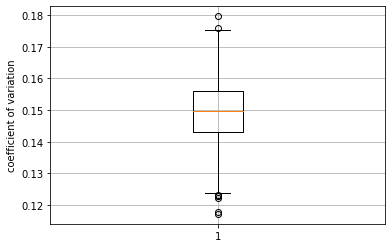

In [43]:
print(np.median(c_v))
plt.ylabel("coefficient of variation")
plt.grid()
plt.boxplot(c_v,);

In [44]:
X_nov = np.concatenate((X_train[:14], dt_cv[best_idx][1]))
X_nov.shape

(314, 9)

### incluindo o coeficiente de variação como parâmetro

In [55]:
X_w_cv = obj_1.inverse_transform(X_nov)
X_w_cv = pd.DataFrame(X_w_cv)
X_w_cv.head()

,0,1,2,3,4,5,6,7,8
0,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
1,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
2,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
3,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
4,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964


In [61]:
X_w_cv = np.concatenate((X_w_cv, np.expand_dims(np.std(X_w_cv, axis=1)/np.mean(X_w_cv, axis=1),axis=1))
                        ,axis=1)

In [68]:
obj_2 = scaler(-1, 1)
obj_2.fit(pd.DataFrame(X_w_cv))
X_wc_t = obj_2.transform(X_w_cv)

In [110]:
X_cand_wc = obj_1.inverse_transform(X_cand)
X_cand_wc = np.concatenate((X_cand_wc, np.expand_dims(np.std(X_cand_wc, axis=1)/np.mean(X_cand_wc, axis=1)
                                                      ,axis=1)),axis=1)
X_cand_wc = pd.DataFrame(X_cand_wc, index=X_cand.index)

In [112]:
X_cand_wc_t = obj_2.transform(X_cand_wc)

In [113]:
X_train_wc = obj_1.inverse_transform(X_train)
X_train_wc = np.concatenate((X_train_wc, np.expand_dims(np.std(X_train_wc, axis=1)/np.mean(X_train_wc, axis=1)
                                                      ,axis=1)), axis=1)
X_train_wc = obj_2.transform(X_train_wc)

In [114]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.01, gamma="auto").fit(X_wc_t) #0.0138

print("score no treinamento: ", np.mean(clf.predict(X_wc_t)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train_wc[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train_wc[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train_wc)==1))

score no treinamento:  0.9840764331210191
score nos genes de referência de treinamento:  0.8571428571428571
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.85


In [115]:
X_cand_wc_t.shape

(4185, 10)

In [116]:
pca_real = PCA(n_components=2).fit(X_train_wc)

In [117]:
X_cand_svm = X_cand_wc_t[clf.predict(X_cand_wc_t)==1]
X_cand_svm.shape

(948, 10)

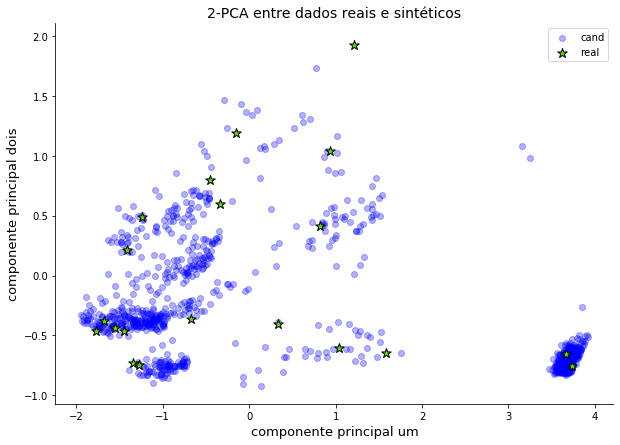

In [118]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_train_wc_pca = pca_real.transform(X_train_wc)
X_cand_pca = pca_real.transform(X_cand_svm)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_wc_pca[:,0], X_train_wc_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [119]:
print("redução do ", (1 - X_cand_svm.shape[0]/X_cand.shape[0])*100,"% no processo de escolha de candidatos")

redução do  77.34767025089606 % no processo de escolha de candidatos


In [120]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [121]:
print(X_cand_svm.loc[rg_moose].dropna().shape[0])
X_cand_svm.loc[rg_moose].dropna()

11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,0,1,2,3,4,5,6,7,8,9
gene,,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512,-0.987438
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083,-0.192924
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020,-0.748716
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169,-0.179191
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640,-0.024674
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314,-0.892056
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330,-0.811597
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720,-0.066368
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242,-0.927401


In [122]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [123]:
X_cand_svm.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9
gene,,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031,-0.868278
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996,-0.333041
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060,-0.892754
ychF,0.969259,1.012508,-0.312707,0.978325,-0.502400,0.922555,0.751064,0.574691,0.696657,-0.006063
